# RSCAM Assessment 3 - solution


### Simulating Langevin dynamics

We assume we have some complicated potential energy function $U(q)$, and the target distribution $\rho_\beta(q)$ where 
$$\rho_\beta(q) = \frac1{Z_\beta} \exp(-\beta U(q)),\qquad Z_\beta=\int_{-\infty}^\infty \exp(-\beta U(q) )\,\rm{d}q.$$
Ultimately we want to compute averages with respect to this distribution, which we can write as an integral against $\rho_\beta(q)$.

If we augment our distribution to include momentum $p$, then we can write 
$$\rho_\beta(q,p) = \frac1{\hat{Z}_\beta} \exp(-\beta H(q,p) ),\qquad \hat{Z}_\beta=\int_{-\infty}^\infty \exp(-\beta H(q,p) )\,\rm{d}q\rm{d}p,$$
where $H$ is the familiar Hamiltonian, or total energy function, that we've seen before
$$H(q,p) = \frac12 \|p\|^2 + U(q)$$
where we have assumed mass is 1 for all degrees of freedom.   (It is easy to change this if we wanted to include a nonunit mass, but just complicates the notation a bit.)

As $q$ and $p$ are independent, we can integrate out over the momentum variables and recover the correct sampling in $q$.  This means that we can think of the momenta as intermediate or 'auxiliary' variables if our main goal is to compute averages of q-dependent functions.

In [1]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt 
from IPython.display import HTML
plt.rc('font', size=14) # makes the fonts used in graphs a bit larger (and clearer)!

The momentum variables are useful as they can allow a system to continue going in an unfavourable direction (i.e. up barriers) via inertia. This property is lacking in, for example, Brownian dynamics.

The equations of motion for Langevin dynamics are
$${ \begin{array}{rcl}
\dot{q} &=& p\\
\dot{p} &=& -\nabla U(q) - \gamma p + \sqrt{2\gamma /\beta} \dot{W}\end{array}}$$
where $W$ is a Wiener process, and $\gamma>0$ is the _friction constant_, a parameter that describes how rapidly energy is dissipated from the system to its surroundings as well as the rate at which the momentum is randomized ($\gamma$ should be viewed as a rate). Note that if $\gamma=0$ then the system reduces to the constant energy (Hamiltonian) dynamics that we looked at earlier in the term when we studied symplectic methods. If $\gamma$ is large, or infinite, then solutions will tend towards solutions to Brownian dynamics, as mentioned in lecture.   In between, $\gamma$ alters the way we converge to equilibrium (or the rate at which averages of functions taken along stochastic paths converge to their long term (ensemble) averages.

We can rewrite Langevin dynamics as the sum of three terms:


$$\left[ \begin{array}{c} \dot{q}\\ \dot{p} \end{array}\right]
= \underbrace{\left[\begin{array}{c} p \\0 \end{array}\right]}_\text{A}
+ \underbrace{\left[\begin{array}{c} 0\\F(q) \end{array}\right]}_\text{B}
+ \underbrace{\left[\begin{array}{c} 0\\-\gamma p + \sqrt{2\gamma/\beta} \dot{W} \end{array}\right]}_\text{O}.$$
As usual $F(q)=-\nabla U(q)$ denotes the force.

As discussed in lecture, we can solve each of the pieces _exactly_ in the weak (distributional) sense:

$$\text{(A) dynamics step}$$
$$ \left| \begin{array}{rcl} 
q(t+h)&\leftarrow&q(t) + h  p(t) \\
\qquad p(t+h)&\leftarrow&p(t)
\end{array}\right.$$

$$\text{(B) dynamics step}$$
$$ \left| \begin{array}{rcl} 
q(t+h)&\leftarrow&q(t) \\
\qquad p(t+h)&\leftarrow&p(t) + h F(q(t))
\end{array}\right.$$

$$\text{(O) dynamics step}$$
$$ \left| \begin{array}{rcl} 
q(t+h)&\leftarrow&q(t) \\
R(t+h)&\leftarrow& \text{Normal}(0,I)\\
\qquad p(t+h)&\leftarrow&\exp(-\gamma h) p(t) + \sqrt{1/\beta}\sqrt{1-\exp(-2\gamma h)} R(t+h)
\end{array}\right.$$

The solution of the O step comes from the solution for the Ornstein-Uhlenbeck process, with $R(t)\in\mathbb{R}^N$ a vector of independent and identically distributed (i.i.d.) normal random numbers.

### Exercise 1.  
Complete the codes for the `B_step` and `O_step` functions below to match the above algorithms. (1 mark)

In [2]:
def A_step( qp , h ):
    q,p = qp
    
    q = q + h*p
    
    return [q,p]

def B_step( qp , h, force ):
    q,p = qp
    
    F = force(q)
    
    p = p + h*F
    
    return [q,p]

def O_step( qp , h,gamma, beta ):
    q,p = qp
    
    alpha = np.exp(-h*gamma)
    
    R = np.random.randn( q.size ).reshape( q.shape)
    p = p * alpha + np.sqrt((1-alpha*alpha)/beta) * R
    
    return [q,p]

Next we can define a method integrating Langevin Dynamics by performing these steps in sequence. For example, the _ABO_ method looks like this:

In [3]:
def ld_ABO(q,p,h,gamma,beta,force):
    
    # The algorithm "ABO" does A then B then O 
    
    qp = [q,p]  #this just translates the separate q and p vectors 
                #into a single vector composed from the pair.
    
    qp_A = A_step(qp , h )
    qp_AB = B_step( qp_A, h, force)
    qp_ABO = O_step( qp_AB, h, gamma, beta )
    q,p = qp_ABO
    
    return q , p 

We can feed this function into the `run_simulation` function  (see below) as the 'step_function' argument. Note that beta, the reciprocal temperature parameter, must be fed through the functions together with gamma.

In [4]:
def run_simulation( q0,p0, Nsteps, h, gamma, beta, step_function, force_function):
    
    q_traj = [np.copy(q0)] 
    p_traj = [np.copy(p0)]
    t_traj = [0]

    q = np.copy(q0) 
    p = np.copy(p0)
    t = 0 

    for n in range(Nsteps):
        q,p = step_function(q, p, h, gamma, beta, force_function)
        t = t + h 

        q_traj += [q] 
        p_traj += [p]   
        t_traj += [t] 

    q_traj = np.array(q_traj) 
    p_traj = np.array(p_traj) 
    t_traj = np.array(t_traj) 

    return q_traj, p_traj, t_traj

In discussing the evolving distribution associated to the numerical method, one normally thinks of taking a large number of separate sampling paths and using the snapshots of them at a given time as a discrete approximation to the evolving probability distribution.

On the other hand, if one is interested in the long term averages, it is not necessary to use this approach.   Rather than taking many walkers and looking at the evolving distributions, one may run a single, long simulation. It can be shown that taking averages over this long simulation is equivalent to looking at the large time limit of lots of walkers, i.e. time averages along a trajectory will still equal averages with respect to the target distribution.

For example, for a Gaussian we can look at the sampled distributions generated by a single path as follows:

In [5]:
def force_Gaussian(q):
    # U(q) = q^2 /2
    F = -q 
    return F

# Initialize one walker from a Gaussian distribution

q0 = np.random.randn(1)
p0 = np.random.randn(1)

Nsteps = 10**7
h = 0.0005
gamma = 1.0
beta = 1.0

# Run one long trajectory of Nsteps, using the ABO scheme
q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_ABO, force_Gaussian)

And then plot the resulting trajectories of the $q$ variable and the distributions marginalised in $q$ and $p$:

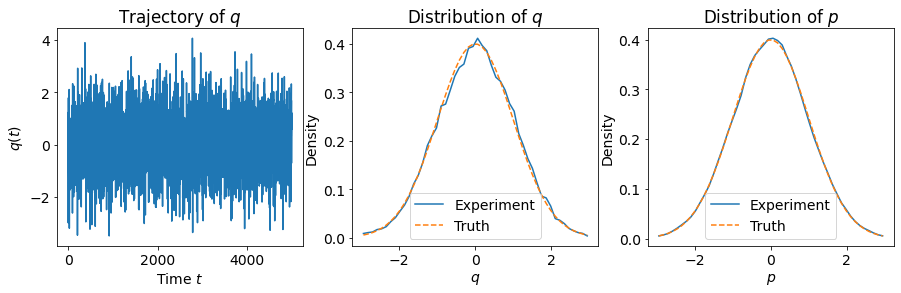

In [6]:
fig = plt.figure(figsize=[15,4])

plt.subplot(1,3,1)
plt.plot( t_traj, q_traj )
plt.title('Trajectory of $q$')
plt.ylabel('$q(t)$')
plt.xlabel('Time $t$')

plt.subplot(1,3,2) 
histogram,bins = np.histogram(q_traj,bins=50,range=[-3,3], density=True)
midx = (bins[0:-1]+bins[1:])/2
rho = np.exp(- beta*(midx**2)/2)
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
plt.plot(midx,histogram,label='Experiment')
plt.plot(midx,rho,'--',label='Truth')
plt.title('Distribution of $q$')
plt.xlabel('$q$')
plt.ylabel('Density')
plt.legend()

plt.subplot(1,3,3) 
histogram,bins = np.histogram(p_traj,bins=50,range=[-3,3], density=True)
midx = (bins[0:-1]+bins[1:])/2
rho = np.exp(- beta*(midx**2)/2)
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
plt.plot(midx,histogram,label='Experiment')
plt.plot(midx,rho,'--',label='Truth')
plt.title('Distribution of $p$')
plt.xlabel('$p$')
plt.ylabel('Density')
plt.legend()
plt.show()

Discuss the gap between the distribution of points generated by the numerical method and the exact, true Gaussian distribution.   

<font color="blue">Notice that although the behavior is qualitatively as we would expect, there is a substantial gap between the distribution of points generated by the numerical method and the exact, true Gaussian distribution.   The  momentum distribution appears to be more accurate than that of the positions.   There is evidence of random sampling error which seems to be greater near $q=0$ (or $p=0$ in the case of the momenta)</font> 

### Exercise 2
Examine the above distributions obtained using histograms of the trajectories.  What happens to their accuracy (i.e. the difference between the histogram envelope and the dashed curve) if you (a) decrease or increase the stepsize, (b) decrease or increase the number of timesteps?  You may need quite significant increases in the number of steps to see a difference. (2 marks)

<font color="blue">
   (a) We will look at what happens when we vary the stepsize.  It makes sense to look at 5 cases (two stepsizes which are smaller than h=0.5 and two which are larger).  There is no rule for choosing these so we will take h_1 =0.125, h_2 =0.25, h_3 = 0.5, h_4= 1, h_5 =2.  There is also no rule for how we display the results, except that we should be compact in our answers.  So let us focus on the configurational distribution.
    </font>

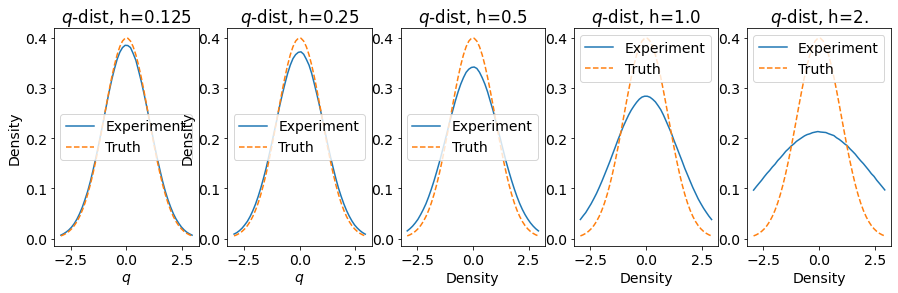

In [7]:
fig = plt.figure(figsize=[15,4])
h = 0.125 # Run one long trajectory of Nsteps, using the ABO scheme
q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_ABO, force_Gaussian)
plt.subplot(1,5,1) 
histogram,bins = np.histogram(q_traj,bins=50,range=[-3,3], density=True)
midx = (bins[0:-1]+bins[1:])/2
rho = np.exp(- beta*(midx**2)/2)
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
plt.plot(midx,histogram,label='Experiment')
plt.plot(midx,rho,'--',label='Truth')
plt.title('$q$-dist, h=0.125')
plt.xlabel('$q$')
plt.ylabel('Density')
plt.legend()

h = 0.25 # Run one long trajectory of Nsteps, using the ABO scheme
q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_ABO, force_Gaussian)
plt.subplot(1,5,2) 
histogram,bins = np.histogram(q_traj,bins=50,range=[-3,3], density=True)
midx = (bins[0:-1]+bins[1:])/2
rho = np.exp(- beta*(midx**2)/2)
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
plt.plot(midx,histogram,label='Experiment')
plt.plot(midx,rho,'--',label='Truth')
plt.title('$q$-dist, h=0.25')
plt.xlabel('$q$')
plt.ylabel('Density')
plt.legend()

h = 0.5 # Run one long trajectory of Nsteps, using the ABO scheme
q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_ABO, force_Gaussian)
plt.subplot(1,5,3) 
histogram,bins = np.histogram(q_traj,bins=50,range=[-3,3], density=True)
midx = (bins[0:-1]+bins[1:])/2
rho = np.exp(- beta*(midx**2)/2)
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
plt.plot(midx,histogram,label='Experiment')
plt.plot(midx,rho,'--',label='Truth')
plt.title('$q$-dist, h=0.5')
plt.xlabel('$q$')
plt.xlabel('Density')
plt.legend()

h = 1.0 # Run one long trajectory of Nsteps, using the ABO scheme
q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_ABO, force_Gaussian)
plt.subplot(1,5,4) 
histogram,bins = np.histogram(q_traj,bins=50,range=[-3,3], density=True)
midx = (bins[0:-1]+bins[1:])/2
rho = np.exp(- beta*(midx**2)/2)
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
plt.plot(midx,histogram,label='Experiment')
plt.plot(midx,rho,'--',label='Truth')
plt.title('$q$-dist, h=1.0')
plt.xlabel('$q$')
plt.xlabel('Density')
plt.legend()

h = 2 # Run one long trajectory of Nsteps, using the ABO scheme
q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_ABO, force_Gaussian)
plt.subplot(1,5,5) 
histogram,bins = np.histogram(q_traj,bins=50,range=[-3,3], density=True)
midx = (bins[0:-1]+bins[1:])/2
rho = np.exp(- beta*(midx**2)/2)
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
plt.plot(midx,histogram,label='Experiment')
plt.plot(midx,rho,'--',label='Truth')
plt.title('$q$-dist, h=2.')
plt.xlabel('$q$')
plt.xlabel('Density')
plt.legend()
plt.show()

<font color="blue"> The pictures make it clear that the accuracy of the distribution is directly correlated with the stepsize.  As the stepsize is decreased the approximation becomes more refined.  However in all cases there is substantial jaggedness in the histogram envelopes due to random sampling error.
    
(b) Now for the issue, we look at what happens as we increase or decrease the number of steps taken.   We will again produce 5 histograams.  To simplify things we can just compute one long trajectory and use different parts of it to compute the histograms.  This will show how things converge with increasing numbers of steps.  We will take the stepsize to be the original h=0.5 here.  As the hint indicates, a little experimentation demonstrates that we have to dramatically increase Nsteps to see much of a difference.  We will use Nsteps values of 100, 1000, 10000, 100000, 1000000 to compute the histograms.  The last one is the only trajectory we actually need to compute.  If your computer is not up to doing so many steps you can do less.
</font>

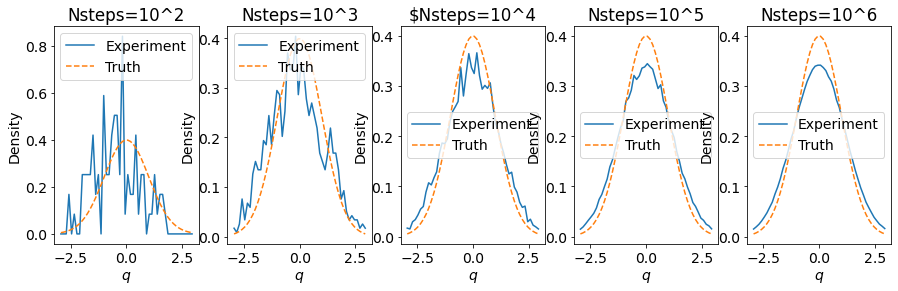

In [8]:
fig = plt.figure(figsize=[15,4])
h = 0.5 # Run one long trajectory of Nsteps, using the ABO scheme
Nsteps=1000000
q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_ABO, force_Gaussian)
plt.subplot(1,5,1) 
histogram,bins = np.histogram(q_traj[1:100,:],bins=50,range=[-3,3], density=True)
midx = (bins[0:-1]+bins[1:])/2
rho = np.exp(- beta*(midx**2)/2)
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
plt.plot(midx,histogram,label='Experiment')
plt.plot(midx,rho,'--',label='Truth')
plt.title('Nsteps=10^2')
plt.xlabel('$q$')
plt.ylabel('Density')
plt.legend()

plt.subplot(1,5,2) 
histogram,bins = np.histogram(q_traj[1:1000,:],bins=50,range=[-3,3], density=True)
midx = (bins[0:-1]+bins[1:])/2
rho = np.exp(- beta*(midx**2)/2)
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
plt.plot(midx,histogram,label='Experiment')
plt.plot(midx,rho,'--',label='Truth')
plt.title('Nsteps=10^3')
plt.xlabel('$q$')
plt.ylabel('Density')
plt.legend()

plt.subplot(1,5,3) 
histogram,bins = np.histogram(q_traj[1:10000,:],bins=50,range=[-3,3], density=True)
midx = (bins[0:-1]+bins[1:])/2
rho = np.exp(- beta*(midx**2)/2)
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
plt.plot(midx,histogram,label='Experiment')
plt.plot(midx,rho,'--',label='Truth')
plt.title('$Nsteps=10^4')
plt.xlabel('$q$')
plt.ylabel('Density')
plt.legend()

plt.subplot(1,5,4) 
histogram,bins = np.histogram(q_traj[1:100000,:],bins=50,range=[-3,3], density=True)
midx = (bins[0:-1]+bins[1:])/2
rho = np.exp(- beta*(midx**2)/2)
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
plt.plot(midx,histogram,label='Experiment')
plt.plot(midx,rho,'--',label='Truth')
plt.title('Nsteps=10^5')
plt.xlabel('$q$')
plt.ylabel('Density')
plt.legend()

plt.subplot(1,5,5) 
histogram,bins = np.histogram(q_traj[1:1000000,:],bins=50,range=[-3,3], density=True)
midx = (bins[0:-1]+bins[1:])/2
rho = np.exp(- beta*(midx**2)/2)
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
plt.plot(midx,histogram,label='Experiment')
plt.plot(midx,rho,'--',label='Truth')
plt.title('Nsteps=10^6')
plt.xlabel('$q$')
plt.ylabel('Density')
plt.legend()
plt.show()

<font color="blue"> What we can see here is that the first histogram is extremely 'noisy' due to using only 100 samples.  As we increase the number of samples the histogram becomes more and more refined but we become more aware of the error due to using a large stepsize (which we see as a gap between the blue and orange dashed curves).
    
You could stop here and not lose any marks, but is it not tempting to try to put these results together and try a small stepsize (h=0.125) and a large number of steps (Nsteps=10^6)?  
    </font>
    

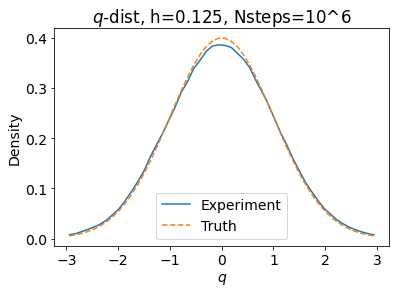

In [9]:
fig = plt.figure()
h = 0.125 # Run one long trajectory of Nsteps, using the ABO scheme
Nsteps=1000000
q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_ABO, force_Gaussian)
histogram,bins = np.histogram(q_traj[:,:],bins=50,range=[-3,3], density=True)
midx = (bins[0:-1]+bins[1:])/2
rho = np.exp(- beta*(midx**2)/2)
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
plt.plot(midx,histogram,label='Experiment')
plt.plot(midx,rho,'--',label='Truth')
plt.title('$q$-dist, h=0.125, Nsteps=10^6')
plt.xlabel('$q$')
plt.ylabel('Density')
plt.legend()
plt.show()

<font color="blue"> Now we see that when the stepsize is small and the number of steps large, we can get a much better approximation.  There is still a visible error.  To get rid of it we would need to take even smaller steps and possibly use even more steps...  This motivates looking for better methods! 
    </font>

### Exercise 3
Implement the _BAOAB_ method. (1 mark)

*Recall that if a character appears twice in the string describing the method then the corresponding integration is for time $h/2$, rather than $h$.*

In [10]:
def ld_BAOAB(q,p,h,gamma,beta, force):
    
    qp = [q,p]
    
    qp_B = B_step(qp, h/2, force)
    qp_BA = A_step(qp_B , h/2 )
    qp_BAO = O_step( qp_BA, h, gamma, beta )
    qp_BAOA = A_step( qp_BAO, h/2)
    qp_BAOAB = B_step(qp_BAOA , h/2, force )
    
    q,p = qp_BAOAB
    
    return q , p 



# Exercise 4
Refer to Exercise 2 for methodology.

Compare the exact distribution to sampled distributions computed using _BAOAB_ by making plots of their q trajectories and q and p marginal densities (as done above for the Gaussian case). Compute distributions in both configurations ($q$) and momenta ($p$), for the potential energy function shown below. Use Nsteps = 10000, a stepsize of $h=0.1$, $\gamma=1$, and $\beta=1.0$ 
$$U(q) = q^2(.1+\sin^2(q))$$
Discuss the results obtained. (2 marks)

*(Run using one walker for a long enough simulation so that your histogram looks smooth. Include axis labels, legends and titles where necessary.)*

In [11]:
def my_pot(q):
    U= (q**2)*(np.sin(q)**2 +0.1)
    return U
def my_force(q):
    # U(q) = q**2*(sin(q)**2 + 0.1)
    
    F = -2*q*(np.sin(q)**2 +0.1) - 2*q**2*np.sin(q)*np.cos(q)
    
    return F

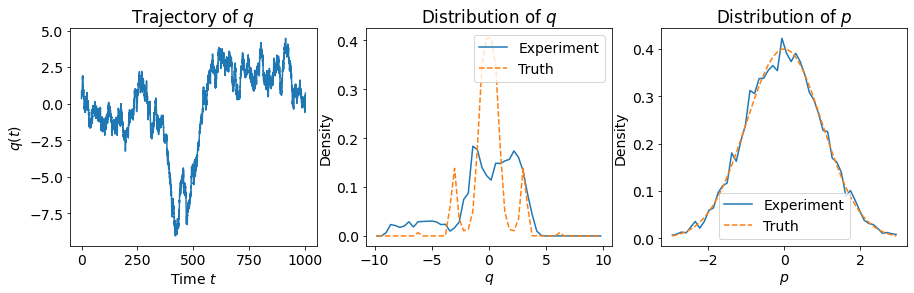

In [12]:

q0 = np.random.randn(1)
p0 = np.random.randn(1)

Nsteps = 10000
h = 0.1
gamma = 100.0
beta = 1.0

# Run one long trajectory of Nsteps, using the BAOAB scheme
q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_ABO, my_force)
fig = plt.figure(figsize=[15,4])

plt.subplot(1,3,1)
plt.plot( t_traj, q_traj )
plt.title('Trajectory of $q$')
plt.ylabel('$q(t)$')
plt.xlabel('Time $t$')

plt.subplot(1,3,2) 
histogram,bins = np.histogram(q_traj,bins=50,range=[-10,10], density=True)
midx = (bins[0:-1]+bins[1:])/2
rho = np.exp(- beta*my_pot(midx))
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
plt.plot(midx,histogram,label='Experiment')
plt.plot(midx,rho,'--',label='Truth')
plt.title('Distribution of $q$')
plt.xlabel('$q$')
plt.ylabel('Density')
plt.legend()

plt.subplot(1,3,3) 
histogram,bins = np.histogram(p_traj,bins=50,range=[-3,3], density=True)
midx = (bins[0:-1]+bins[1:])/2
rho = np.exp(- beta*(midx**2)/2)
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
plt.plot(midx,histogram,label='Experiment')
plt.plot(midx,rho,'--',label='Truth')
plt.title('Distribution of $p$')
plt.xlabel('$p$')
plt.ylabel('Density')
plt.legend()
plt.show()

<font color="blue"> Notice that in order to make this work, we needed to do two things.  First we needed to change the "exact" configurational distribution to be exp(-beta U(q)).  The expression used previously just involved the quadratic potential which we are no longer using here.  The other thing that is different is the longer interval on the $q$-axis which captures more of the interesting behavior.  We can see that the numerically computed approximate distribution is not too far from the exact.   Note that the sharp peaks in the distribution are just artifacts of the limited number of grid points used in representing the distribution...we should use more to get a more refined figure, although we might need to generate more samples using longer trajectories to fill all the small bins in the histogram.
    </font>

We can estimate an 'observable average' of a function $\varphi(q,p)$ by calculating the average of the values of $\varphi(q_n,p_n)$ computed using the method.  For example, to calculate the average of $\varphi(q) = q^2$, just compute $$\frac{1}{N+1}\sum_{n=0}^{N}q_{n}^2$$.


### Exercise 5
This exercise is open-ended and individual.

In this exercise you will explore the use of BAOAB to compute observable averages for the following observable functions:
$$\varphi_1(q) = q^2$$
$$\varphi_2(q) = e^{-q^2}$$

Important - in your experiments, leave beta fixed at 1.0 as it represents a reciprocal physical temperature, i.e. a feature of the model. Changing beta could result in a much different problem. By contrast gamma, Nsteps and stepsize h can all be viewed as 'free parameters' and they are just things that can be adjusted to get the best possible result for the least computational effort.  

You may vary any of gamma, Nsteps and stepsize.  You will need to do this systematically for each observable function.  Also bear in mind that the quantities you are computing such as an observable will have random variation due to the numbers of samples collected, and the particular stochastic paths followed.  In the limit of large N and small h, you should converge to a single exact value, but it might be beyond the abilities of your computer to do so!

Note that it is possible to compute the reference value of each average by using numerical quadrature (integration methods).  For example to compute the reference value for $\varphi_1$, first import scipy's integrate package:
> import scipy.integrate as integrate

then calculate as follows:
> Z = integrate.guad(lambda q: np.exp(- beta * my_pot(q)), -10,10)[0]

> avg = integrate.quad( lambda q: q**2 * np.exp(- beta * my_pot(q)), -10,10)[0]/Z

The division by Z is needed because the density is not normalised.  The limits -10 to 10 are somewhat arbitrary...we just need to be sure the integrand is nearly zero outside the range.

In reporting your work it is not necessary to provide every graph you generate in your notebook...in particular you should clean up your answers to improve presentation.  Focus in particular on these two questions:
<ul>
  
<li>
    Which observable is most difficult to compute, $\varphi_1$ or $\varphi_2$? Explain by first discussing the graphs of the two observable functions in relation to the graph of the configurational density function.   Clarify your statement by performing numerical experiments.
</li>
<li>  What is the best result you can obtain using either method for $\varphi_2$ with a "force budget" of 20000 F-evaluations?    Bear in mind the stochastic variation in the computed results you obtain, so you might run a number of independent sampling runs and average to compute the mean and even compute the standard deviation of the estimates you obtain. </li>
</ul>
(4 marks)
    

<font color="blue"> 
    Let us begin by computing the 'exact' values of the observable averages.   We can then use these in subsequent computations.  We will call them O1 and O2.
    </font>

In [13]:
import scipy.integrate as integrate
Z1 = integrate.quad(lambda q: np.exp(-beta * my_pot(q)), -10,10)
O1 = integrate.quad( lambda q: q**2 * np.exp(- beta * my_pot(q)), -10,10)[0]/Z1[0]
print("O1 = ", O1)
Z2 = integrate.quad(lambda q: np.exp(-beta * my_pot(q)), -10,10)
O2 = integrate.quad( lambda q: np.exp(-q**2) * np.exp(- beta * my_pot(q)), -10,10)[0]/Z1[0]
print("O2 = ", O2)

O1 =  2.3539799379204998
O2 =  0.5653404356145665


<font color="blue"> We can double check that the intervals used [-10,10] are big enough in each case by just increasing the interval a little to see if the value changes. </font>

In [14]:
import scipy.integrate as integrate
Z1 = integrate.quad(lambda q: np.exp(-beta * my_pot(q)), -15,15)
O1 = integrate.quad( lambda q: q**2 * np.exp(- beta * my_pot(q)), -15,15)[0]/Z1[0]
print("O1 = ", O1)
Z2 = integrate.quad(lambda q: np.exp(-beta * my_pot(q)), -15,15)
O2 = integrate.quad( lambda q: np.exp(-q**2) * np.exp(- beta * my_pot(q)), -15,15)[0]/Z1[0]
print("O2 = ", O2)

O1 =  2.3539824410248325
O2 =  0.5653404265049548


<font color="blue">
Next, let us compute the observable estimates from the SDE, using the Langevin integrator.  We will call the resulting estimates O1_est and O2_est.  We first compute a long path to serve as the basis for this, then just calculate the target averages using the points of the path.
</font>

In [15]:
Nsteps = 10000
h = 0.1
gamma = 1.0
beta = 1.0

# Run one long trajectory of Nsteps, using the BAOAB scheme
q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_BAOAB, my_force)
O1_est = sum(q_traj**2)/(Nsteps+1)
O2_est = sum(np.exp(-q_traj**2))/(Nsteps+1)
print("O1 estimated = ", O1_est)
print("O2 estimated = ", O2_est)


O1 estimated =  [2.68417361]
O2 estimated =  [0.52688472]


<font color="blue">
The results are not very good. There can be several causes.  First, the stepsize might be too large.  Second the trajectory might be too short.  Even if these are addressed, there is a third possible problem: the observable might be very hard to compute because the calculation relies on seeing parts of the distribution that are very rarely accessed (even though their probability is low).  This is precisely the issue with the first observable.  Since it involves the square of q, we can see that it will weight more strongly large value of $q$ but these are rarely seen points in the SDE paths!    We will next increase the number of steps to 400000 and vary the stepsize to see how the observable averages are converging when there are, one would think, sufficient steps for good resolution.  A little experimentation shows that the problem can be unstable when h>0.2, so we will use the four steps h=0.025, 0.05, 0.1, 0.2. [This calculation took a few minutes and made the fan start up on my laptop, meaning the computer was working a little!]
</font>

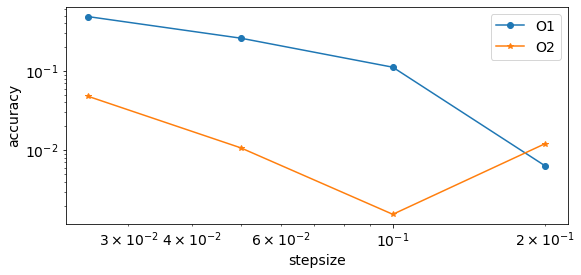

In [16]:
Nsteps = 400000
h_lis = [0.025,0.05,0.1,0.2] # we choose 4 stepsizes
gamma = 1.0
beta = 1.0
O1_est= np.zeros(4)
O2_est= np.zeros(4)

for ii in range(4):
    # Run one long trajectory of Nsteps, using the BAOAB scheme, stepsize h[ii]
    q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h_lis[ii], gamma, beta, ld_BAOAB, my_force)
    O1_est[ii] = sum(q_traj**2)/(Nsteps+1)
    O2_est[ii] = sum(np.exp(-q_traj**2))/(Nsteps+1)

fig = plt.figure(figsize=[9,4])
plt.loglog(h_lis,np.abs(O1_est-O1),"o-")
plt.loglog(h_lis,np.abs(O2_est-O2),"*-")
plt.legend(["O1", "O2"]);
plt.xlabel('stepsize')
plt.ylabel('accuracy')
plt.show()



<font color="blue"> This graph answers the first question very clearly: the 2nd observable is easier to compute than the first.  Let us graph the observables together with the density function.
    </font>

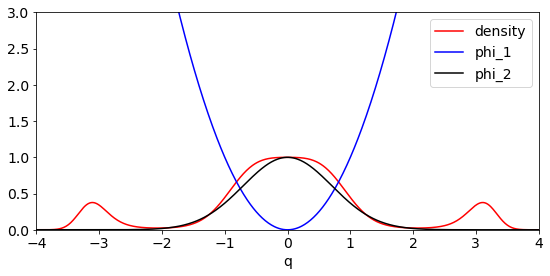

In [17]:
q_points = np.linspace(-6,6,1000)
fig = plt.figure(figsize=[9,4])
plt.plot(q_points,np.exp(-beta*my_pot(q_points)),'r')
plt.plot(q_points,q_points**2,'b')
plt.plot(q_points,np.exp(-q_points**2),'k')
plt.xlim(-4,4)
plt.ylim(0,3)
plt.legend(["density","phi_1","phi_2"])
plt.xlabel('q')
plt.show()

<font color="blue"> Because $\varphi_1$ grows with increasing $|q|$, it means that the points around $q=3$ contribute substantially to the observable integral and also to the time integral.  However, due to the small probability of actually reaching that value (since it requires getting past a significant barrier in the potential) the calculation will not be very accurate unless we have extremely long paths.  By contrast the second observable function falls off to zero in those regions which means that we don't need to visit those rare states to get an accurate approximation.
    </font>

<font color="blue">
The second question bears quite a bit of experimentation.  We can get a hint by computing the histograms with 10000 steps for various stepsizes.   (Using the code as written, we have two F-evals per timestep)
    </font>

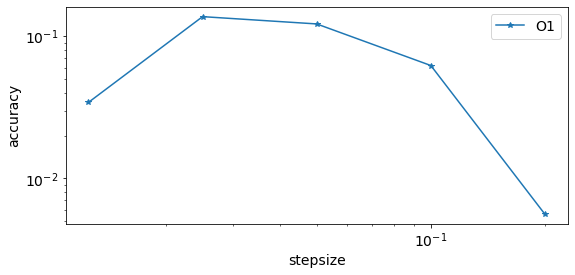

In [18]:
Nsteps = 10000
h_lis = [0.0125, 0.025,0.05,0.1,0.2] # we choose 5 stepsizes
gamma = 1.0
beta = 1.0
O1_est= np.zeros(5)
O2_est= np.zeros(5)

for ii in range(5):
    # Run one long trajectory of Nsteps, using the BAOAB scheme, stepsize h[ii]
    q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h_lis[ii], gamma, beta, ld_BAOAB, my_force)
    O1_est[ii] = sum(q_traj**2)/(Nsteps+1)
    O2_est[ii] = sum(np.exp(-q_traj**2))/(Nsteps+1)

fig = plt.figure(figsize=[9,4])
plt.loglog(h_lis,np.abs(O2_est-O2),"*-")
plt.legend(["O1", "O2"]);
plt.xlabel('stepsize')
plt.ylabel('accuracy')
plt.show()

<font color="blue"> In my experiments on average the best accuracy was obtained for the largest stepsize I could use, h=0.2, about 0.04, but the 100 runs I performed were not enough to eliminate the variance in this estimate for the error.  While it is possible to have much smaller errors for particular runs, it would be impossible in the general setting, where the exact value is not known, to identify which these are, thus it is safer to rely on the average error over many runs. </font>

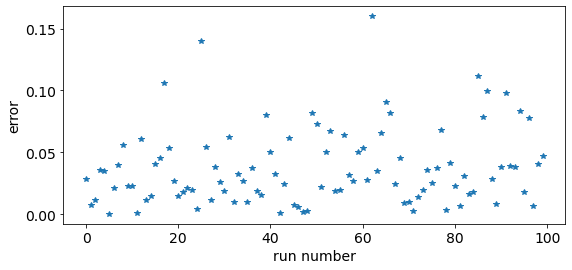

The average error for h=0.2 is  0.03745929771532583


In [19]:
gamma = 1.0
beta = 1.0
h=0.2
Nsteps = 10000
O2_err_list = np.zeros(100)
for nn in range(100):
    q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_BAOAB, my_force)
    O2_est = sum(np.exp(-q_traj**2))/(Nsteps+1)
    O2_err_list[nn] = np.abs(O2_est-O2)
fig = plt.figure(figsize=[9,4])
plt.plot(O2_err_list,'*')
plt.xlabel('run number')
plt.ylabel('error')
plt.show()
print("The average error for h=0.2 is ", sum(O2_err_list)/100)

## Bayesian inference in data science

The purpose of stochastic calculation is usually to calculate integrals (averages) with respect to a target distribution. We shall look at an application for this in Bayesian inference for Gaussian mixture models.  This discussion is very compressed. For a more in-depth (but still very readable) look at Bayesian inference in mixture models, see Ref [1] below.

We will look at one example for inferring a statistical property from data via sampling.

Let's assume there are three types of data mixed together: A, B and C. For concreteness, you could suppose that we have combined three data sets containing mean August high temperatures from three cities at different latitudes which are assumed to be modelled by Gaussian distributions, let us say A = Helsinki, B= Ulan Bator, C = Buenos Aires.  For each city we have a mean and a standard deviation of the corresponding Gaussian.   

If we combine datasets of equal size of August high temperatures from the three cities, we may make the natural ansatz that that any given datum $y$ is modelled by the _probability distribution_ $\hat{\rho}$ of $y$ whose density is just the sum of the three Gaussians.  To simplify things we will further assume in the following that all three of the standard deviations are 3C,  whereas the mean temperatures are unknown.

$$ \hat{\rho}(y\,|\,\mu_A,\mu_B,\mu_C) \propto \exp({-(y-\mu_A)^2/18}) + \exp({-(y-\mu_B)^2/18}) + \exp({-(y-\mu_C)^2}/18)$$

The "18" in each denominator is just $2\sigma^2$, where $\sigma=3$ for each component.

If we know the values of $\mu_A,\,\mu_B$ and $\mu_C$ then we can determine the likelihood of a given temperature coming from the mixture using the above formula. But what if we have the data, and just know there are three cities, but we don't know the three mean temperatures? We can use Bayes theorem to infer them.  That is, we can find the probability distribution for the centres given the data. 

If we have a set of $N$ datapoints $Y = \{y_i\}$, then we can write the distribution for the centres as 

$$ \rho(\mu_A,\mu_B,\mu_C\,|\,Y) \propto  \rho_\text{prior}(\mu_A,\mu_B,\mu_C) \prod_{i=1}^N \hat{\rho}(y_i\,|\,\mu_A,\mu_B,\mu_C),$$
where $\rho_\text{prior}$ is the _prior_ which regularizes the combined distribution, and $\hat{\rho}$ is the _likelihood_ defined above.

The simplest approach to studying the Bayesian model would be to use an 'expectation maximization' method which involves finding the mode (or modes, in this case) of the distribution by maximizing the density.  We will look at a more nuanced method that 
instead explores the probability distribution $\rho$ for the means given some temperature data $Y$. 

The distribution $\rho$ looks very different to the previous distributions we have seen, as there is no potential energy $U(q)$. We will think of $q=[\mu_A,\mu_B,\mu_C]$ and as we can write $\rho(q) = \exp(-\log(\rho(q)))$ we can then think of an effective potential $U(q) = -\log(\rho(q))$.

Thus we have 

$$ U(\mu_A,\mu_B,\mu_C) = -\log( \rho_\text{prior}(\mu_A,\mu_B,\mu_C) ) - \sum_{i=1}^N \log( \hat{\rho}(y_i\,|\,\mu_A,\mu_B,\mu_C) )$$


In data science and statistics, $U$ is called the negative _log-posterior_ instead of the energy.


Ref [1]: http://www.cs.toronto.edu/~rgrosse/csc321/mixture_models.pdf

In [20]:
file_object = open('temperatures.npy', 'rb')
Y= np.load(file_object)
print(Y)

FileNotFoundError: [Errno 2] No such file or directory: 'temperatures.npy'

And then we can make a histogram to look at the distribution of the data:

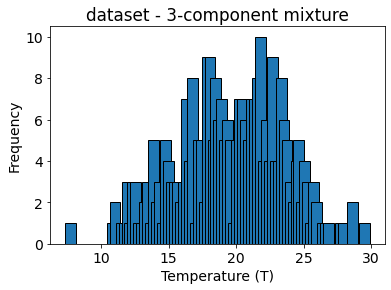

: 

In [ ]:
histogram,bins = np.histogram(Y,bins=100)
mid_bins = (bins[:-1]+bins[1:])/2
plt.bar(mid_bins,histogram,edgecolor='k')
plt.xlabel('Temperature (T)')
plt.ylabel('Frequency')
plt.title('dataset - 3-component mixture')
plt.show()

As we can see here, the temperatures look a bit of a mess, with some low values, even down to under 10 and some high values up to about 30.  The next challenge is to unravel this mess and figure out what the temperatures are for the three cities.  Can you guess this from the above picture?  If you can you are a statistical genius!   It is not at all obvious what the three temperature are.  (...and no peaking using google!)

We shall use a Gaussian prior with a large variance, just to keep us from sampling e.g. negative numbers. We will put the centre of the prior at 20, which is roughly the mean of the data.  Let us take $\sigma =10$  for each of the three means in the prior.

$$ \rho_\text{prior}(\mu_A,\mu_B,\mu_C) \propto \exp({-(20-\mu_A)^2/200}) \exp({-(20-\mu_B)^2/200}) \exp({-(20-\mu_B)^2/200}) $$

### Exercise 6
Create a function that takes the value of the position $q$ and the data vector $y$, and outputs the value of $U(q)$. (2 marks)

*(NOTE: Try to avoid using a loop to sum over all of the data as it will be very slow, and instead work with vectors as much as possible. Don't forget U includes the prior and the likelihood.)*

In [ ]:
def U(q,y):
    m1,m2,m3 = q 
     
    g1 = np.exp(-(y-m1)**2/18)/1 
    g2 = np.exp(-(y-m2)**2/18)/1
    g3 = np.exp(-(y-m3)**2/18)/1 
    
    u = -np.sum( np.log(g1+g2+g3) )
    u += (m1-20)**2/200
    u += (m2-20)**2/200
    u += (m3-20)**2/200 
    
    return u
    
    

: 

In [ ]:
# To check:
U( [15,20,25], Y) - U( [16,21,26], Y)
# This should give approximately -11.23 [corrected value]


-11.230590033085662

: 

### Exercise 7 
Create a function that takes the position $q$ and data $y$ and returns the force $\nabla U(q)$. (2 marks)

In [ ]:
def force(q,y):
    m1,m2,m3 = q 
    
    # write code to compute the three components of the force vector, as well
    # as the potential (by calling the U function above)
    
    g1 = np.exp(-(y-m1)**2/18) 
    g2 = np.exp(-(y-m2)**2/18)
    g3 = np.exp(-(y-m3)**2/18)
    
    u = -np.sum( np.log(g1+g2+g3) )
    u += (m1-20)**2/200
    u += (m2-20)**2/200
    u += (m3-20)**2/200 
    
    f1 =  -np.sum(g1 * (m1-y)/9/ (g1+g2+g3) ) - (m1-20)/100
    f2 =  -np.sum(g2 * (m2-y)/9/ (g1+g2+g3) ) - (m2-20)/100
    f3 =  -np.sum(g3 * (m3-y)/9/(g1+g2+g3) ) - (m3-20)/100
    
    return u, f1,f2,f3

: 

In [ ]:
force( [15,16,31], Y)
# This should give force components as 

#(173.40950408107503, 33.95278379480335, 51.00213777256805, -31.13748859782598)

(173.40950408107503, 33.95278379480335, 51.00213777256805, -31.13748859782598)

: 

### Exercise 8
Use your force routine to generate samples from $\rho$ by generating one long Langevin dynamics trajectory (more, possibly much more than 10,000 steps). 

**Plot envelopes of the histograms of the distributions of $\mu_A,\mu_B,\mu_C$ on the same axis.**

You should see that the values tend to settle into basins around the three defined values.

*(Use BAOAB as your integrator.  It is up to you to choose a sensible stepsize $h$ and friction $\gamma$, and run for long enough to get smooth curves.)*

Discuss the three envelope curves.    You should comment on their similarities and differences. The fact that there are three modes creates an interesting problem: there is  an interchangeability in the data.  We could swap any two of the $\mu_\alpha$ and it would not change the distribution of the data.  This ability to swap parameters is sometimes referred to as fungibility and it makes the study slightly more difficult.

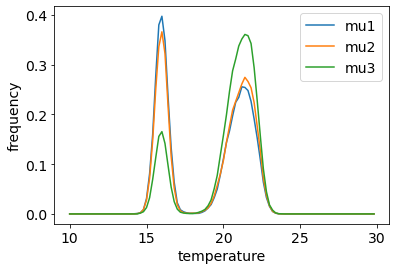

: 

In [ ]:
p1 = np.random.randn(1)
p2 = np.random.randn(1)
p3 = np.random.randn(1)

q1 = 16 + 2*np.random.randn(1)
q2 = 20 + 2*np.random.randn(1)
q3 = 22 + 2*np.random.randn(1)

h = 0.1
V = [] 
K = [] 
Q = [] 
C = [] 
gamma =0.5
beta = 1

c1 = np.exp(-h*gamma)
c3 = np.sqrt(1-c1*c1)*np.sqrt(1/beta)
pe,f1,f2,f3 = force([q1,q2,q3],Y)

for ii in range(200000):
    
    # B
    p1 += (h/2)*f1
    p2 += (h/2)*f2
    p3 += (h/2)*f3
    
    # A
    q1 += (h/2)*p1
    q2 += (h/2)*p2
    q3 += (h/2)*p3
    
    # O
    p1 = c1*p1 + c3*np.random.randn(1)
    p2 = c1*p2 + c3*np.random.randn(1)
    p3 = c1*p3 + c3*np.random.randn(1) 
    
    # A
    q1 += (h/2)*p1
    q2 += (h/2)*p2
    q3 += (h/2)*p3
    
    pe,f1,f2,f3 = force([q1,q2,q3],Y)
    
    # B 
    p1 += (h/2)*f1
    p2 += (h/2)*f2
    p3 += (h/2)*f3
    
    ke = p1**2 + p2**2 + p3**2
    ke /= 2
    
    V += [pe]
    K += [ke]
    Q += [ np.copy([q1,q2,q3]) ]
    C += [ [q2-q1,2*q3-q2-q1]]
    
V = np.array(V).ravel()
K = np.array(K).ravel()
Q = np.array(Q)[:,:,0]
C = np.array(C)[:,:,0]

qq = Q #np.sort(Q,1)


aa1,bb1 = np.histogram( qq[:,0] ,range=[10,30],bins=100,density=True)
aa2,bb2 = np.histogram( qq[:,1] ,range=[10,30],bins=100,density=True)
aa3,bb3 = np.histogram( qq[:,2] ,range=[10,30],bins=100,density=True)

plt.plot(bb1[:-1],aa1,label='mu1')
plt.plot(bb2[:-1],aa2,label='mu2')
plt.plot(bb3[:-1],aa3,label='mu3')
plt.legend()
plt.xlabel('temperature')
plt.ylabel('frequency')
plt.show()

<font color="blue"> It is not easy to understand what this picture is telling us. The distributions of mu1, mu2 and mu3 are all jumbled together.  The fact that the frequencies in the intermediate regime around 18 are close to zero is suggestive that there is a relatively rare transition which is slowing down the exploration.  </font>

It can be hard to visualize the system when we have more than two dimensions, so people often use a pair of _collective variables_ and plot results in those instead.

Plot a 2D histogram of your sampled trajectory in the $C_1$ and $C_2$ collective variable coordinates listed below.

$$ C_1 = \mu_B - \mu_A $$
$$ C_2 = 2*\mu_C - \mu_B - \mu_A $$

These formulas are chosen by trial and error to provide a suitable 2d projection of the system to separate the important domains.

_(You may wish to plot the logarithm of the histogram value instead, which is more closely related to energy and makes a nice picture.)_

You should see a finite set of regions where sampling is concentrated.
(4 marks)

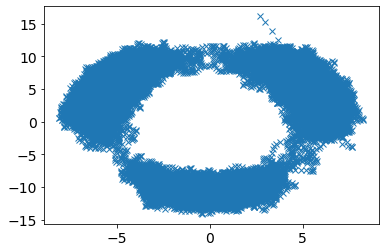

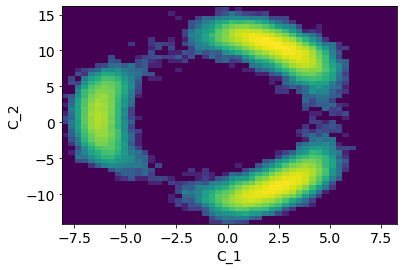

: 

In [ ]:
plt.plot(C[:,0],C[:,1],'x')
plt.show()
aa,bb,cc = np.histogram2d(C[:,0],C[:,1],bins=50)
aa[aa==0] = np.min(aa[aa>0])
plt.pcolor(bb,cc,np.log(aa))
plt.xlabel('C_1')
plt.ylabel('C_2')
plt.show()

<font color="blue">
    The figure confirms what we might have guessed...there are some rare transitions due to the difficulty of going from one state to another.  Even though the swapped temperatures are equally likely, the transitions are rare which makes sampling a little difficult. 
    </font>

The problem has a symmetry in it, due to invariance under label permutation.   This means that the three sampled regions above are really effectively the same region with some projection mapping between them. We can remove this by collapsing the results onto one well.

In general finding this projection can be very difficult, but here it is easy to accomplish. A transition between any of the three regions amounts to two of the $\mu$ values swapping positions, so we can undo that by sorting our trajectory to maintain a size ordering.

### Exercise 9
Use `np.sort` to create a copy of your trajectory with sorted components so that $\mu_A<\mu_B<\mu_C$. Plot a new histogram of the distributions of the sorted $\mu_A,\mu_B,\mu_C$ on the same axis, and print the means of each of the three coordinates.

You should see that each density is concentrated around just one value.   What are the high temperatures in August in the three cities? (2 marks)

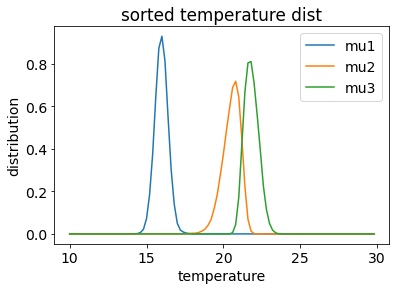

[16.07138967 20.61593227 21.92480687]


: 

In [ ]:
qq = np.sort(Q,1)


aa1,bb1 = np.histogram( qq[:,0] ,range=[10,30],bins=100,density=True)
aa2,bb2 = np.histogram( qq[:,1] ,range=[10,30],bins=100,density=True)
aa3,bb3 = np.histogram( qq[:,2] ,range=[10,30],bins=100,density=True)

plt.plot(bb1[:-1],aa1,label='mu1')
plt.plot(bb2[:-1],aa2,label='mu2')
plt.plot(bb3[:-1],aa3,label='mu3')
plt.xlabel('temperature')
plt.ylabel('distribution')
plt.title('sorted temperature dist')
plt.legend()
plt.show()

print( np.mean( qq,0) )

<font color="blue">
We find the temperatures are around 16.1, 20.6 and 21.9.  In fact the middle one (which is Helsinki) should be about 20, but the others are essentially correct.  I reran several times getting similar results which suggests that the temperature data, which is after all quite limited, must have contained a slight positive sampling bias.  After tripling the size of the data set (with 900 total temperatures instead of 300, the means came out as 16.1, 20.0 and 22.2, close to spot on).
    
As we see here we can get a good approximation to the right temperatures with a fairly simple technique.  An impressive illustration of enduring benefit of the work of Mr Thomas Bayes (University of Edinburgh, class of 1721).
</font>

**Optional:**
1. Use your A, B and O pieces to implement some higher-order Yoshida Langevin dynamics schemes.
2. Demonstrate that the long-time sampling error for OBABO is second order for $q^2$, and BAOAB is second-order for $p^2$, in the Gaussian case.
3. Study the stability for the BAOAB scheme as $\gamma$ is increased.
4. Modify the three temperatures example to calculate the standard deviations as well as the means from data.  
5. Find the height of the barrier between two of the regions in the three-region histogram.

: 

: 